In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

Time series problem

In [3]:
data = pd.read_csv('renfe.csv')

for i in ['insert_date','start_date','end_date']:
    data[i] = pd.to_datetime(data[i])

#clean the missing data
data['price'] = data['price'].fillna(data['price'].mean())
data = data.dropna()

#change start time and end time to be together
data['start_end_hour'] = data['end_date'] - data['start_date']
data['start_end_hour'] = data['start_end_hour']/np.timedelta64(1,'h')
data['insert_month'] = data['insert_date'].dt.month
data['insert_day'] = data['insert_date'].dt.day
data['insert_hour'] = data['insert_date'].dt.hour
data['insert_min'] = data['insert_date'].dt.minute
data['insert_sec'] = data['insert_date'].dt.second

data = data.drop(['insert_date','start_date','end_date'],1)

#change the categrorical to numberical
data['origin'] = data['origin'].astype('category').cat.codes
data['destination'] = data['destination'].astype('category').cat.codes
data['train_type'] = data['train_type'].astype('category').cat.codes
data['train_class'] = data['train_class'].astype('category').cat.codes
data['fare'] = data['fare'].astype('category').cat.codes

data = data.astype(np.float)

X = data.iloc[:, [0,1,2,4,5,6,7,8,9,10,11]]
Y = data.iloc[:, [3]]

Splite the data because the data is too large, so we splite twice. First is train:test=1:9. Second is train:test = 9:1

In [4]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X.values, Y.values, test_size=.9, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=.1, random_state=42)

RandomForest model

In [5]:
model = RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('MSE:',mse)
R2 = r2_score(y_test, y_pred)
print('R2:',R2)
score_train = model.score(X_train, y_train)
print('Train score:',score_train)
score_test = model.score(X_test,y_test)
print('Test score:',score_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


MSE: 90.7179696168534
R2: 0.8530255926280198
Train score: 0.9712176906830545
Test score: 0.8530255926280198


The coefficient of weight

In [6]:
importances = model.feature_importances_
label = data.columns[[0,1,2,4,5,6,7,8,9,10,11]]
coef = pd.Series(model.feature_importances_, index = label)
imp_coef = coef.sort_values()
print(imp_coef)

insert_month      0.011878
insert_hour       0.025229
insert_day        0.030463
insert_min        0.034823
insert_sec        0.042442
train_type        0.051115
train_class       0.072335
start_end_hour    0.107601
fare              0.170431
destination       0.188235
origin            0.265446
dtype: float64


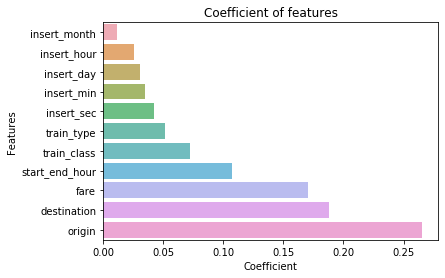

In [23]:
plt.figure()
sns.barplot(imp_coef.values, imp_coef.index, alpha=0.8)
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Coefficient of features')
plt.show()

The visual result

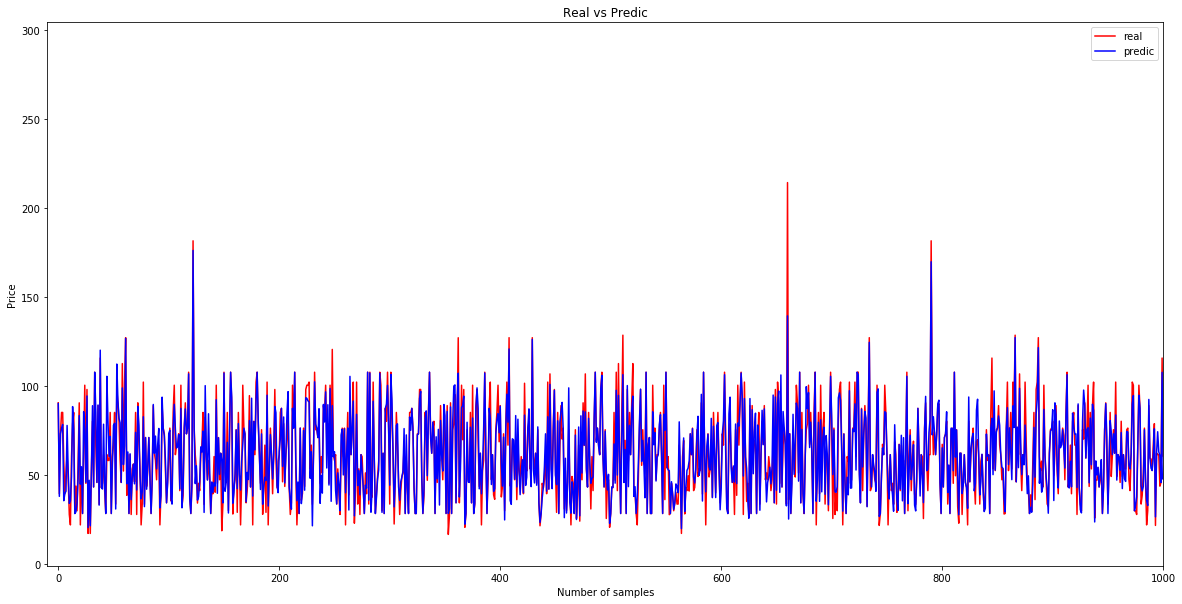

In [25]:
plt.figure(figsize=(20,10))
plt.plot([x for x in range(len(X_test))], y_test, label='real', color='r')
plt.plot([x for x in range(len(X_test))], y_pred, label='predic', color='b')
plt.xlabel('Number of samples')
plt.ylabel('Price')
plt.title('Real vs Predic')
plt.xlim(-10, 1000)
plt.legend()
plt.show()

Learning curve

In [16]:
cv=ShuffleSplit(n_splits=10,test_size=0.1,random_state=42)

def plot_curve():
    # instantiate
    model = RandomForestRegressor(n_estimators=100,random_state=42)

    # fit
    model.fit(X_train1, y_train1)
    
    train_sizes, train_scores, test_scores = learning_curve(model, X_train1, y_train1, 
                                                            n_jobs=-1, cv=cv, 
                                                            train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit, ax=plt.subplots()
    #plt.figure()
    ax.set_title("Random Forest")
    ax.legend(loc="best")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    #ax.gca().invert_yaxis()
    
    # box-like grid
    ax.grid()
    
    # plot the std deviation as a transparent range at each training set size
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    ax.set_ylim(0.5,1)
    legend = ax.legend()
    plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


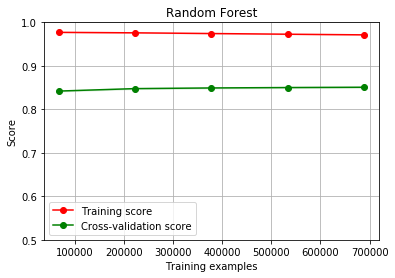

In [22]:
plot_curve()